In [164]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import thinkstats2 as ts2
import thinkplot
import numpy as np
import scipy
import scipy.stats as st

In [61]:
df = pd.read_csv('app/data-capture-2-10-904.csv')
df.drop(['NOTES:', 'Unnamed: 11', 'Unnamed: 12', 'alignment'], axis=1, inplace=True)
df = df.rename(columns={
      "xxz": "seq",
      "x (out of 300)": "x",
      "y (out of 400)": "y",
      "# of characters": "chars",
      "font size": "font_size",
      "# of words": 'words',
      "lines of text": 'lines',
      "caps or lowercase": 'caps'
    })
df['weight'] = df['font weight'].apply(lambda x: x.split(' ')[-1])
df['condensed'] = df['font weight'].str.contains('condensed').astype(int)
df.drop('font weight', axis=1, inplace=True)
df = df.replace(
    {'weight':{
        'light': 0,
        'regular': 1,
        'medium': 2,
        'bold': 3
     },
     'caps': {
         'C': 1,
         ' C': 1,
         'L': 0
     }
})
df['log_font_size'] = np.log(df.font_size)
df['log_chars'] = np.log(df.chars)
df.rotation = df.rotation.apply(fix_angle)
continuous_vars = ['seq','x', 'y', 'rotation', 'log_font_size', 'log_chars']

In [18]:
def fix_angle(angle):
    if angle > 180.0:
        return 360.0 - angle 
    elif angle == 0:
        return 0.0
    else:
        return -angle

In [236]:
def generate_multivariate_gaussian(r, means, stdev, n_samples=500):
    # r is the desired covariance matrix.

    # Generate samples from three independent normally distributed random
    # variables (with mean 0 and std. dev. 1).
    x = st.norm.rvs(size=(r.shape[0], n_samples), 
                    loc=np.reshape(means, (2,1)),
                    scale=np.reshape(stdev, (2,1)))
    # We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
    # the Cholesky decomposition
    
    # Compute the Cholesky decomposition.
    c = scipy.linalg.cholesky(r, lower=True)
 
    # Convert the data to correlated random variables. 
    y = np.dot(c, x)
    return y

In [327]:
def draw_from_closest(data, draw_col, draw_val, target_col):
    data.loc[:,'distance'] = (data[draw_col] - draw_val).abs()
    return_val = data.sort_values('distance').head(5).sample(1).iloc[0][target_col]
    return return_val

In [328]:
class PosterGenerator(object):
    poster_width = 300
    poster_height = 400
    xy_params = {}
    chars_params = None
    dist_choice = {
        'x': st.beta,
        'y': st.beta,
        'chars': st.lognorm
    }
    sims = {}
    n_elements = 12
    data = None
    
    def simulate_data(self, data):
        cols = data.columns
        results = generate_multivariate_gaussian(data.cov().values, 
                                                 data.mean().values, 
                                                 data.std().values)

        res = pd.DataFrame(results).T.rename(columns={i:v for i, v in enumerate(cols)})
        return res
        
    def fit(self, data):
        self.data=data
        for val in range(1, self.n_elements+1):
            xdist = self.dist_choice['x']
            ydist = self.dist_choice['y']
            self.xy_params[val] = {
                'x': xdist.fit(data[data.seq==val].x/self.poster_width),
                'y': ydist.fit(data[data.seq==val].y/self.poster_height)
            }
        self.chars_params = self.dist_choice['chars'].fit(data.chars)
        data['log_chars'] = np.log(data.chars)
        data['log_font_size'] = np.log(data.font_size)
#        char_v_font = data[['log_chars','log_font_size']]
#        self.sims[('chars', 'font_size')] = self.simulate_data(char_v_font)
#        self.sims[('y', 'rotation')] = self.simulate_data(data[['y', 'rotation']]) # TODO: make simulation better
            
    def generate(self):
        elements = []
        for i in range(1, self.n_elements+1):
            element = {}
            # using the seq number draw an X and Y
            xy_sample_params = self.xy_params[i]
            x = self.dist_choice['x'](*xy_sample_params['x']).rvs() * self.poster_width
            y = self.dist_choice['y'](*xy_sample_params['y']).rvs() * self.poster_height
            element.update({'x':x, 'y':y})

            # draw a number of chars, from that draw a font size
            chars = self.dist_choice['chars'](*self.chars_params).rvs()
#             fs_sim = self.sims[('chars', 'font_size')].apply(np.exp)
            font_size = draw_from_closest(self.data[['chars','font_size']], 
                                          'chars', chars, 'font_size')
            element.update({'chars':chars, 'font_size':font_size})
            
            # from Y, draw a rotation
#            rot_sim = self.sims[('y', 'rotation')]
            rotation = draw_from_closest(self.data[['y','rotation']], 'y', y, 'rotation')
            
            # from font size, draw weight, condensed, and capitalization
            wcc = draw_from_closest(self.data[['font_size','weight', 'condensed', 'caps']], 
                                 'font_size', font_size, ['weight', 'condensed', 'caps'])
            weight, condensed, caps = wcc.values
            element.update({'rotation': rotation, 
                            'weight':weight, 
                            'condensed':condensed, 
                            'caps':caps})
            
            elements.append(element)
        return elements

In [ ]:
pg = PosterGenerator()
pg.fit(df)

In [334]:
results = pd.DataFrame(pg.generate())

/Users/brian/.virtualenvs/typeforce/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


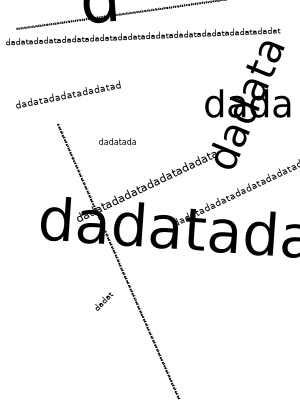

In [335]:
SVG(draw_poster(results))

In [330]:
from IPython.display import SVG
import xml.etree.ElementTree as ET
import math

def dadata(length):
    return ("dadata" * math.ceil(length/6))[:length]

def draw_poster(data):
    svg = ET.Element('svg', xmlns="http://www.w3.org/2000/svg", version="1.1",
                     height="400", width="300")
    txt_settings = {
        "text_anchor":"start",
        "font-family":"Helvetica Neue",
        
    }
    for ix, row in data.iterrows():
        text = ET.SubElement(svg,"text", 
                             x=str(row.x), y=str(row.y),
                             transform="rotate({} {} {})".format(row.rotation, row.x, row.y),
                             #TODO: WEIGHT
                            )
        text.set('font-size', str(row.font_size))
        text.text=dadata(int(row.chars))
    return ET.tostring(svg)

In [288]:
res.std()

log_chars        1.808641
log_font_size    1.092421
dtype: float64

In [107]:
st.beta(*beta_args).rvs()

0.09856591536366241

In [140]:
def test_fit(series, dist):    
    thinkplot.Cdf(ts2.Cdf(series))
    plt.plot(np.linspace(series.min(),series.max(),100), 
             dist(*dist.fit(series)).cdf(np.linspace(series.min(),series.max(),100)))

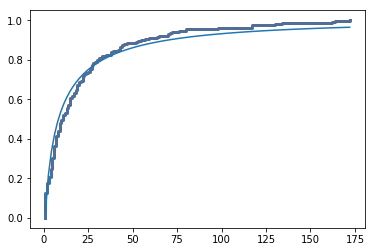

In [260]:
test_fit(df.chars, st.lognorm)


log_font_size    2.790239
log_chars        2.305049
dtype: float64

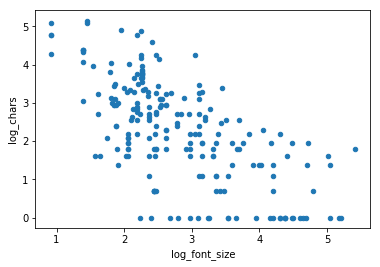

In [285]:
study = df[['log_font_size', 'log_chars']]
study.plot(kind='scatter', x='log_font_size', y='log_chars')
study.mean()

In [286]:
study.std()

log_font_size    0.946359
log_chars        1.332533
dtype: float64

In [307]:
results = generate_multivariate_gaussian(study.cov().values, 
                                         [0,0], 
                                         [1,1])

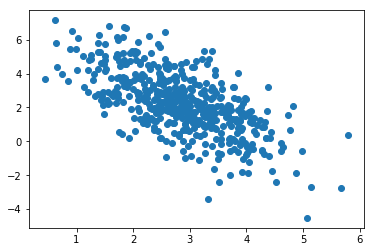

In [316]:
plt.scatter(*(results * np.reshape(study.std().values, (2,1)))+np.reshape(study.mean().values, (2,1)))

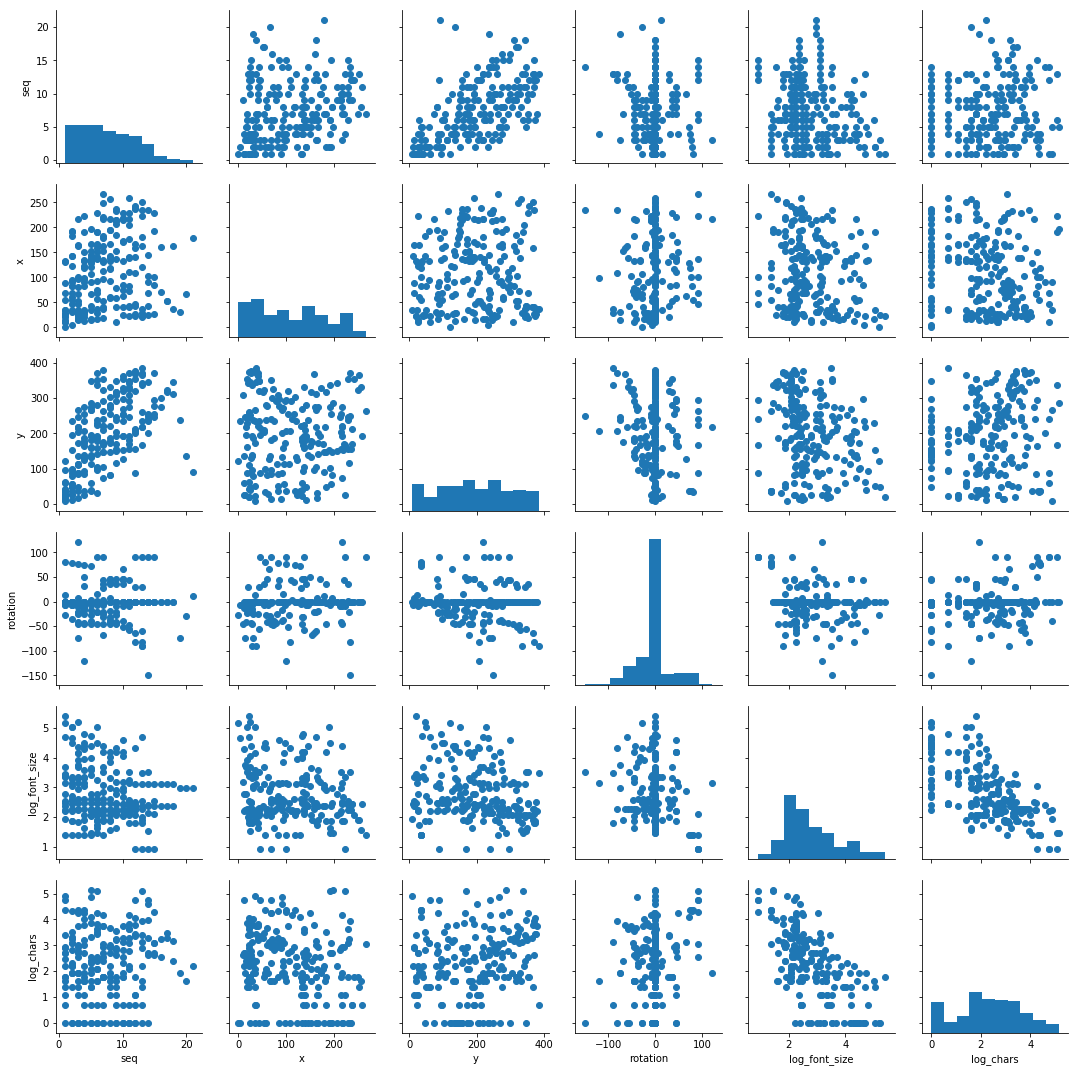

In [62]:
pg = sns.PairGrid(df[continuous_vars])
pg.map_diag(plt.hist)
pg.map_offdiag(plt.scatter)

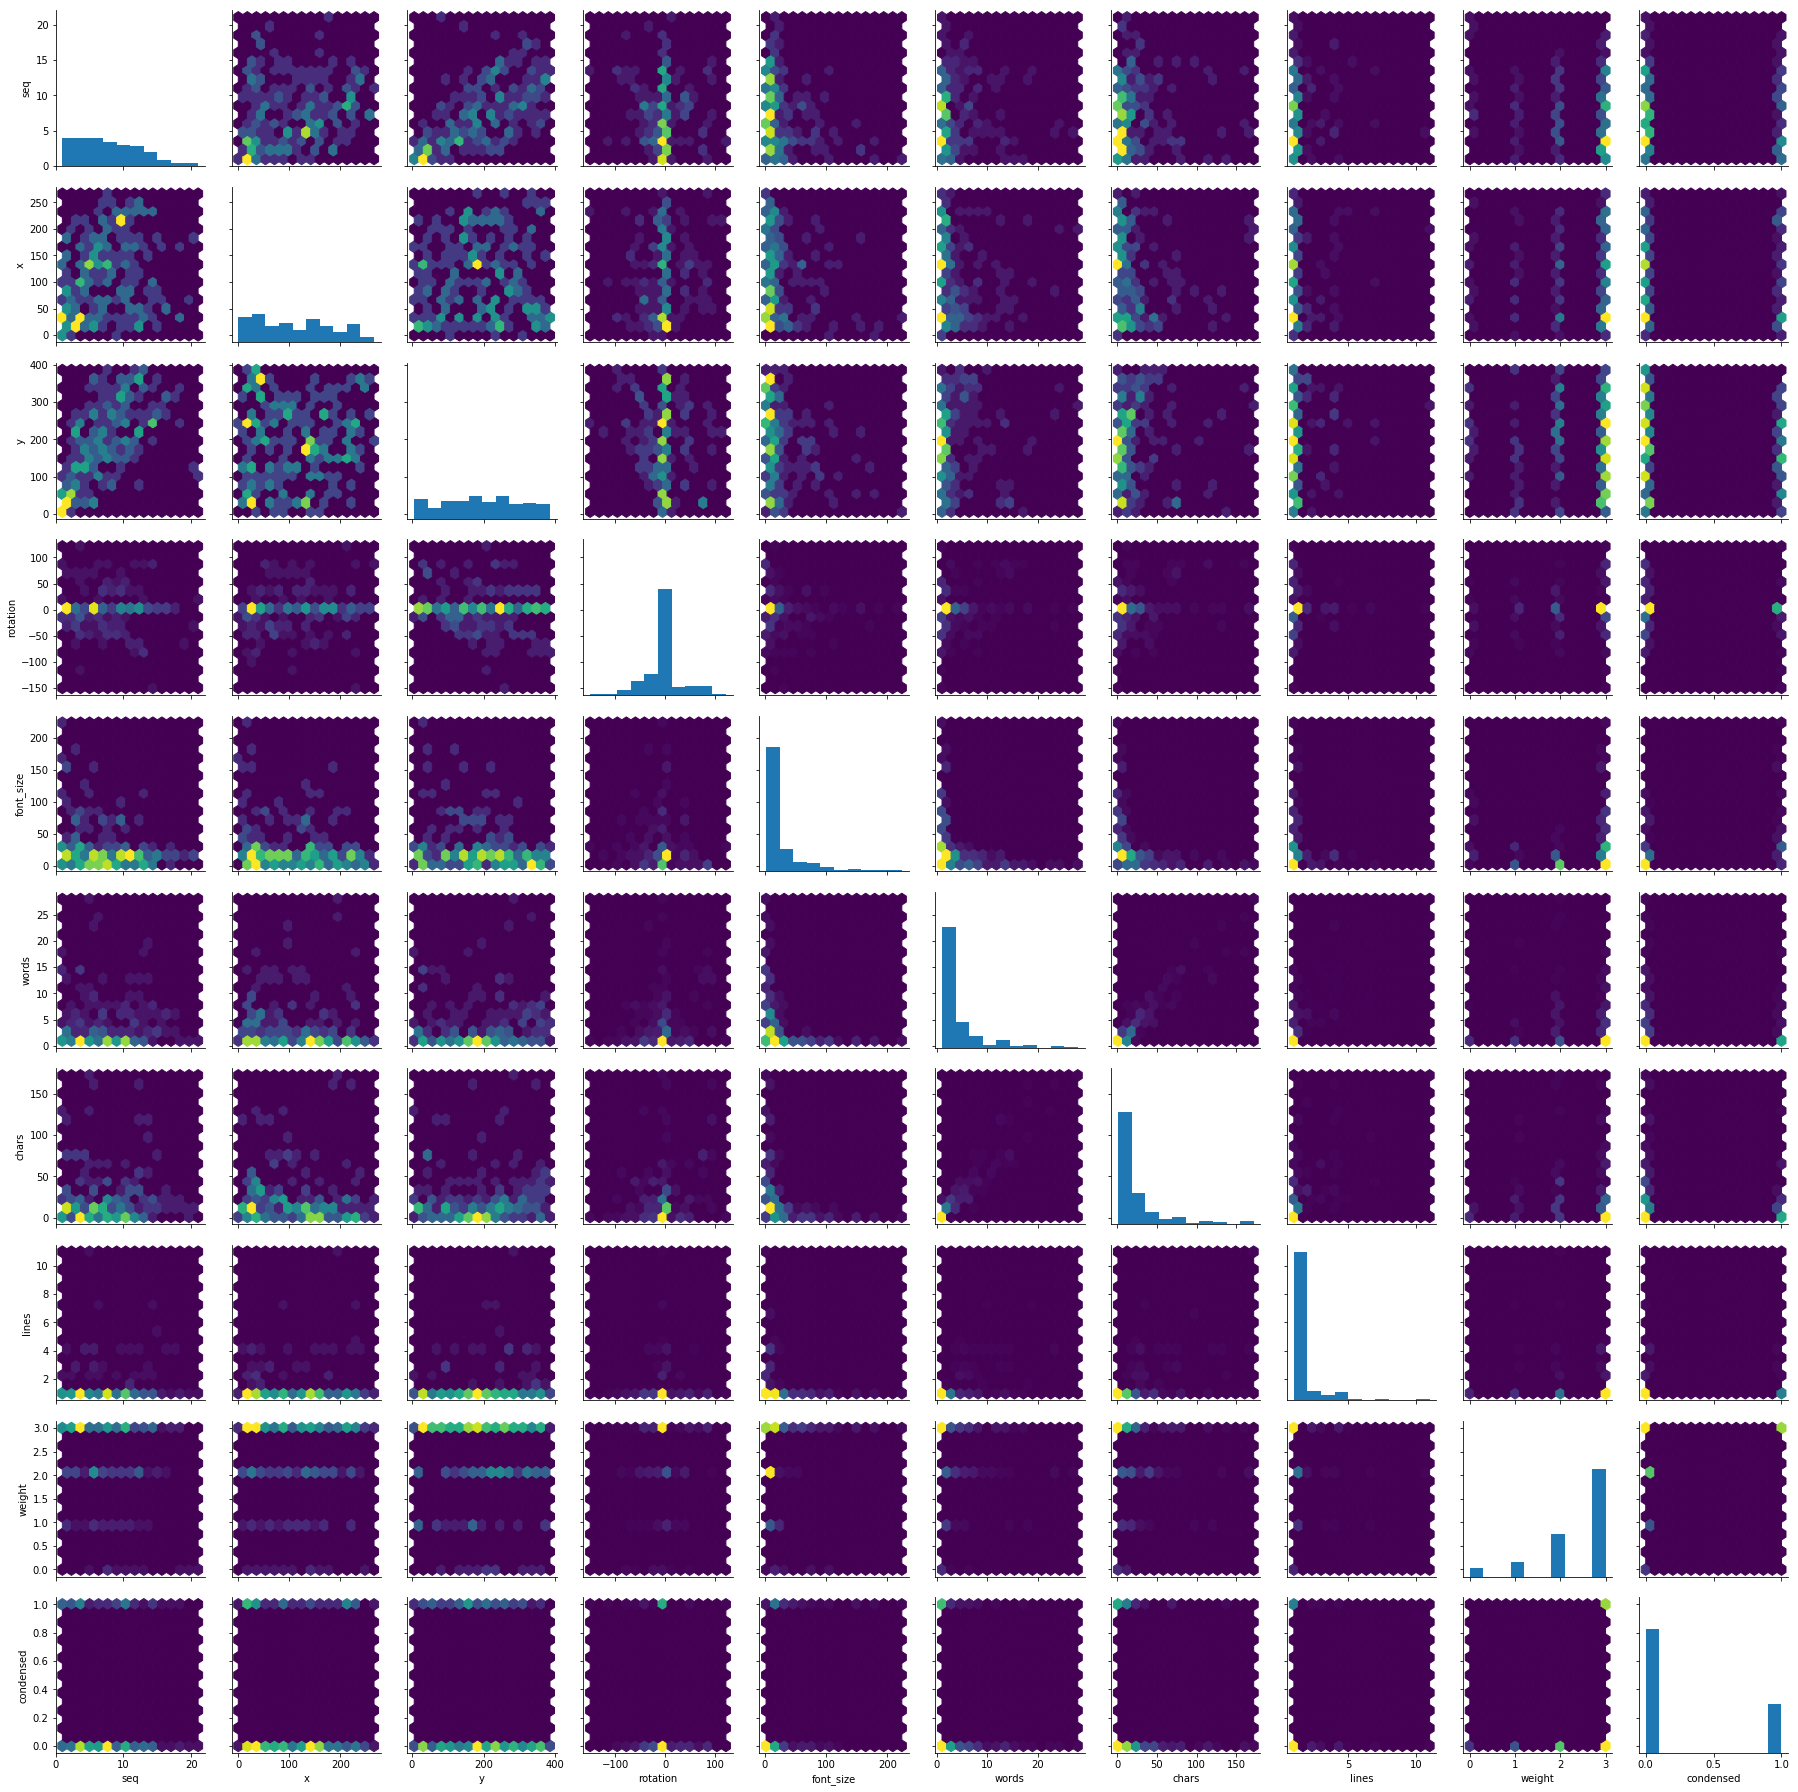

In [43]:
def hexbin(x, y, color, **kwargs):
    del kwargs['cmap']
    plt.hexbin(x, y, gridsize=15, cmap='viridis', **kwargs)

pg = sns.PairGrid(df)
pg.map_diag(plt.hist)
pg.map_offdiag(hexbin, cmap='viridis')

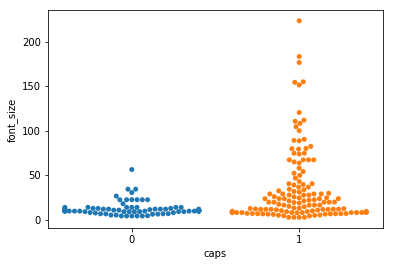

In [56]:
sns.swarmplot(data=df, x='caps', y='font_size')

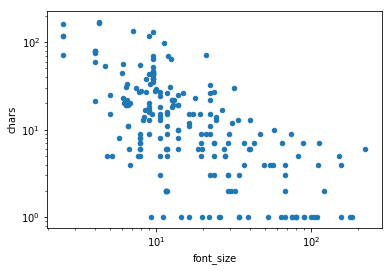

In [17]:
df.plot(kind='scatter', x='font_size', y='chars', logx=True, logy=True)